## 1 Import Libraries (including Plotly)

In [9]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from jax import grad
import jax.numpy as jnp
from jax.scipy.stats import norm as jnorm
from scipy.interpolate import griddata
from scipy.ndimage import gaussian_filter
import plotly.graph_objects as go
from plotly.offline import init_notebook_mode

## 2) Black-Scholes Function

In [8]:
def black_scholes(S, K, T, r, sigma, q=0, otype="call"):
    d1 = (jnp.log(S/K) + (r-q+0.5*sigma**2)*T) / (sigma * jnp.sqrt(T))
    d2 = d1 - sigma * jnp.sqrt(T)
    if otype == "call":
        return S*jnp.exp(-q*T)*jnorm.cdf(d1) - K*jnp.exp(-r*T)*jnorm.cdf(d2)
    else:
        return K*jnp.exp(-r*T)*jnorm.cdf(-d2) - S*jnp.exp(-q*T)*jnorm.cdf(-d1)


## 3) Bisection IV Solver

In [10]:
def solve_for_iv_bisection(S, K, T, r, price, otype="call", tol=1e-6, max_iter=100):
    if T <= 0:
        return np.nan
    sigma_low, sigma_high = 0.01, 5.0
    for _ in range(max_iter):
        sigma_mid = (sigma_low + sigma_high) / 2
        price_mid = float(black_scholes(S, K, T, r, sigma_mid, otype=otype))
        if abs(price_mid - price) < tol:
            return sigma_mid
        if price_mid > price:
            sigma_high = sigma_mid
        else:
            sigma_low = sigma_mid
    return sigma_mid


## 4)Fetch Option Data

In [11]:
ticker_symbol = "SPY"
ticker = yf.Ticker(ticker_symbol)
S = ticker.history(period="1d")["Close"].iloc[-1]  # current stock price
r = 0.05

expirations = ticker.options[:5]
all_options = []

for exp in expirations:
    chain = ticker.option_chain(exp)
    for df, otype in [(chain.calls, "call"), (chain.puts, "put")]:
        temp = df.copy()
        temp["type"] = otype
        temp["expirationDate"] = pd.to_datetime(exp)
        all_options.append(temp)

options_df = pd.concat(all_options)
today = datetime.today()
options_df["T"] = (options_df["expirationDate"] - today).dt.days / 365


## 5) Compute IVs for all options

In [12]:
ivs, strikes, expiries, market_prices, option_types, market_IVs = [], [], [], [], [], []

for idx, row in options_df.iterrows():
    K = row["strike"]
    T = row["T"]
    price = row["lastPrice"]
    otype = row["type"]
    market_iv = row.get("impliedVolatility", np.nan)
    
    own_iv = solve_for_iv_bisection(S, K, T, r, price, otype=otype)
    
    if not np.isnan(own_iv):
        ivs.append(own_iv)
        strikes.append(K)
        expiries.append(row["expirationDate"])
        market_prices.append(price)
        option_types.append(otype)
        market_IVs.append(market_iv)

ivs = np.array(ivs)
market_IVs = np.array(market_IVs)
strikes = np.array(strikes)
expiries = np.array(expiries)
market_prices = np.array(market_prices)
option_types = np.array(option_types)


## 6) Create Comparison Table

In [ ]:
comparison_df = pd.DataFrame({
    "Strike": strikes,
    "Expiration": expiries,
    "OptionType": option_types,
    "MarketPrice": market_prices,
    "ComputedIV": ivs,
    "MarketIV": market_IVs
})

comparison_df["TheoreticalPrice"] = [
    float(black_scholes(S, K, (exp-today).days/365, r, sigma, otype=otype))
    for K, exp, sigma, otype in zip(strikes, expiries, ivs, option_types)
]

comparison_df["PriceError"] = np.abs(comparison_df["TheoreticalPrice"] - comparison_df["MarketPrice"])
comparison_df["IV_Error"] = comparison_df["ComputedIV"] - comparison_df["MarketIV"]


## 7️) Compute Accuracy Metrics

In [13]:
def calc_metrics(df):
    IV_Error = df["IV_Error"]
    Price_Error = df["PriceError"]
    return {
        "MAE_IV": IV_Error.abs().mean(),
        "MaxAE_IV": IV_Error.abs().max(),
        "RMSE_IV": np.sqrt((IV_Error**2).mean()),
        "MAE_Price": Price_Error.mean(),
        "MaxAE_Price": Price_Error.max(),
        "RMSE_Price": np.sqrt((Price_Error**2).mean())
    }

metrics_all = calc_metrics(comparison_df)

In [14]:
# ATM ±15% moneyness
atm_lower, atm_upper = S*0.85, S*1.15
mask_atm = (comparison_df["Strike"] >= atm_lower) & (comparison_df["Strike"] <= atm_upper)
metrics_atm = calc_metrics(comparison_df[mask_atm])

print("===== Accuracy Metrics (All Traded Options) =====")
for k,v in metrics_all.items():
    print(f"{k}: {v:.4f}")

print("\n===== Accuracy Metrics (ATM ±15% Moneyness) =====")
for k,v in metrics_atm.items():
    print(f"{k}: {v:.4f}")

display(comparison_df[mask_atm].sort_values("Strike").head(10))


===== Accuracy Metrics (All Traded Options) =====
MAE_IV: 0.2505
MaxAE_IV: 3.0533
RMSE_IV: 0.4453
MAE_Price: 1.1208
MaxAE_Price: 138.6282
RMSE_Price: 7.6348

===== Accuracy Metrics (ATM ±15% Moneyness) =====
MAE_IV: 0.1859
MaxAE_IV: 1.0936
RMSE_IV: 0.3049
MAE_Price: 0.5874
MaxAE_Price: 76.8458
RMSE_Price: 3.6826


,Strike,Expiration,OptionType,MarketPrice,ComputedIV,MarketIV,IV_Error,TheoreticalPrice,PriceError
663,510.0,2025-10-01,put,0.02,0.3,0.750003,-0.450003,6.692667e-22,0.020000
1020,510.0,2025-10-03,put,0.01,0.3,0.609379,-0.309379,1.323559e-13,0.010000
75,510.0,2025-09-29,put,0.01,0.3,1.062505,-0.762505,0.000000e+00,0.010000
854,510.0,2025-10-03,call,149.73,0.3,1.081792,-0.781792,1.521692e+02,2.439189
176,510.0,2025-09-30,call,153.18,0.3,1.393558,-1.093558,1.519597e+02,1.220283
414,510.0,2025-09-30,put,0.01,0.3,0.859376,-0.559376,3.995552e-32,0.010000
664,515.0,2025-10-01,put,0.01,0.3,0.718753,-0.418753,2.123455e-20,0.010000
1021,515.0,2025-10-03,put,0.01,0.3,0.593754,-0.293754,1.088837e-12,0.010000
76,515.0,2025-09-29,put,0.04,0.3,1.031255,-0.731255,0.000000e+00,0.040000
415,515.0,2025-09-30,put,0.01,0.3,0.828127,-0.528127,6.838207e-30,0.010000


## 8️) 2D IV Comparison Plot

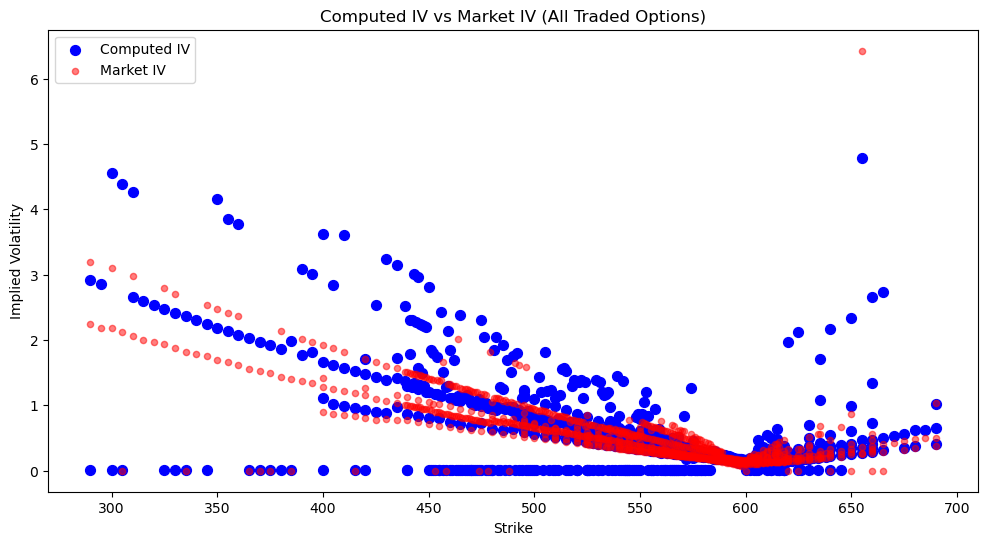

In [15]:
plt.figure(figsize=(12,6))
plt.scatter(strikes, ivs, label="Computed IV", c='blue', s=50)
plt.scatter(strikes, market_IVs, label="Market IV", c='red', s=20, alpha=0.5)
plt.xlabel("Strike")
plt.ylabel("Implied Volatility")
plt.title("Computed IV vs Market IV (All Traded Options)")
plt.legend()
plt.show()


## 9️) 3D IV Surfaces

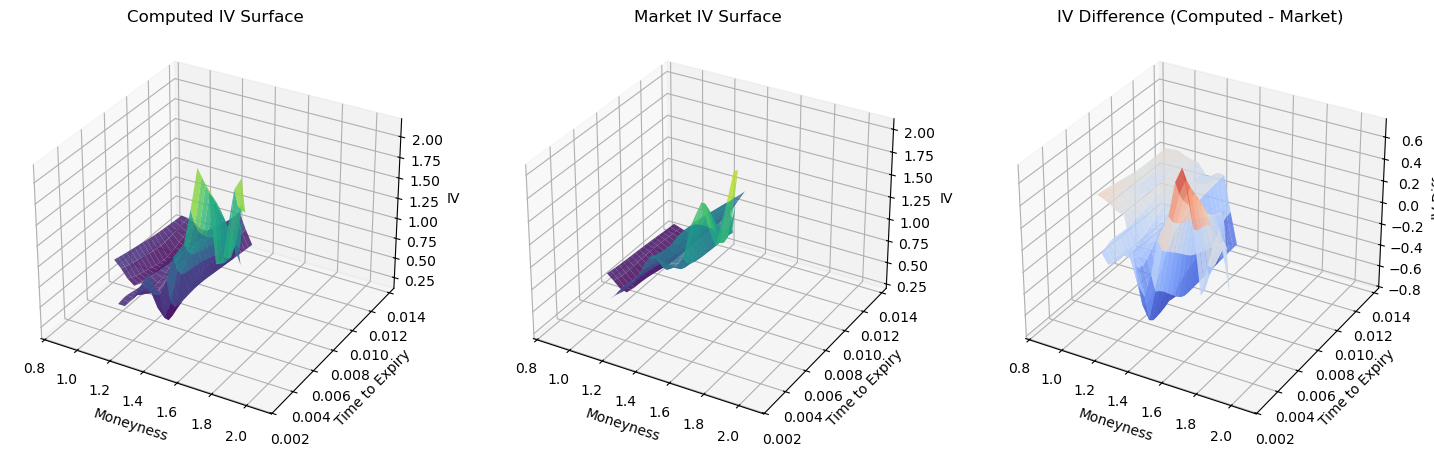

In [16]:
moneyness = S / strikes
dtes = np.array([(exp-today).days/365 for exp in expiries])

m_grid = np.linspace(moneyness.min(), moneyness.max(), 30)
dte_grid = np.linspace(dtes.min(), dtes.max(), 30)
M, D = np.meshgrid(m_grid, dte_grid)

IV_computed_grid = gaussian_filter(griddata((moneyness, dtes), ivs, (M,D), method='linear'), sigma=1)
IV_market_grid = gaussian_filter(griddata((moneyness, dtes), market_IVs, (M,D), method='linear'), sigma=1)
IV_diff_grid = IV_computed_grid - IV_market_grid

fig = plt.figure(figsize=(18,6))

ax1 = fig.add_subplot(1,3,1, projection='3d')
ax1.plot_surface(M,D,IV_computed_grid, cmap='viridis', alpha=0.85)
ax1.set_title("Computed IV Surface")
ax1.set_xlabel("Moneyness")
ax1.set_ylabel("Time to Expiry")
ax1.set_zlabel("IV")

ax2 = fig.add_subplot(1,3,2, projection='3d')
ax2.plot_surface(M,D,IV_market_grid, cmap='viridis', alpha=0.85)
ax2.set_title("Market IV Surface")
ax2.set_xlabel("Moneyness")
ax2.set_ylabel("Time to Expiry")
ax2.set_zlabel("IV")

ax3 = fig.add_subplot(1,3,3, projection='3d')
ax3.plot_surface(M,D,IV_diff_grid, cmap='coolwarm', alpha=0.85)
ax3.set_title("IV Difference (Computed - Market)")
ax3.set_xlabel("Moneyness")
ax3.set_ylabel("Time to Expiry")
ax3.set_zlabel("IV Diff")

plt.show()


## 10) 3D IV Surfaces (ATM ±15%) with Current Stock Price Overlay

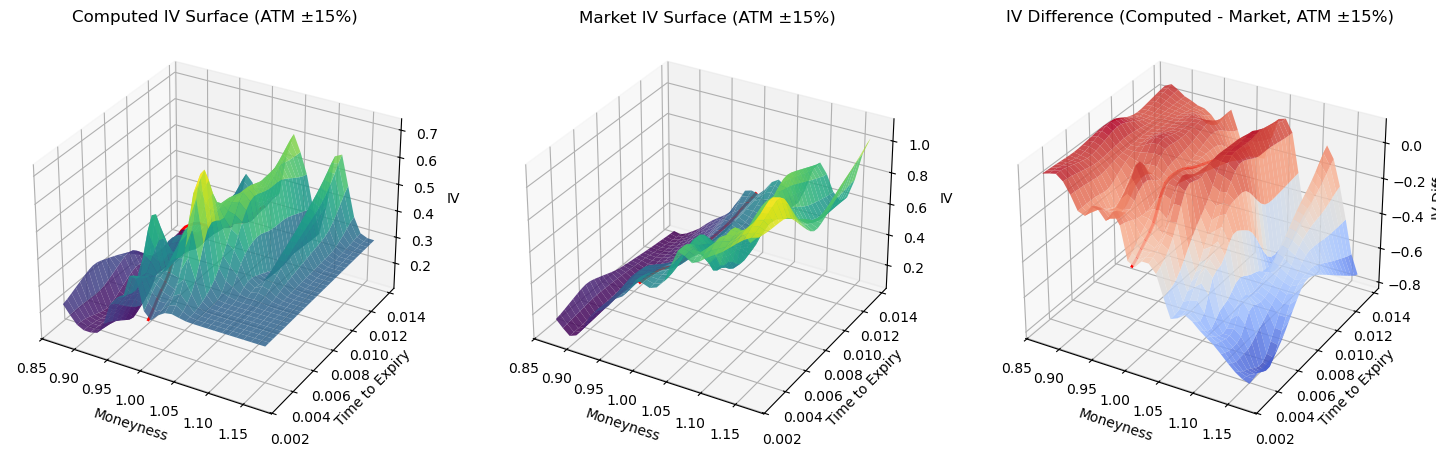

In [17]:
atm_lower, atm_upper = S * 0.85, S * 1.15
mask_atm = (comparison_df["Strike"] >= atm_lower) & (comparison_df["Strike"] <= atm_upper)

strikes_atm = comparison_df["Strike"][mask_atm].values
ivs_atm = comparison_df["ComputedIV"][mask_atm].values
market_IVs_atm = comparison_df["MarketIV"][mask_atm].values
expiries_atm = pd.to_datetime(comparison_df["Expiration"][mask_atm].values)
moneyness_atm = S / strikes_atm
dtes_atm = np.array([(exp - today).days / 365 for exp in expiries_atm])

# Create grid
m_grid_atm = np.linspace(moneyness_atm.min(), moneyness_atm.max(), 30)
dte_grid_atm = np.linspace(dtes_atm.min(), dtes_atm.max(), 30)
M_atm, D_atm = np.meshgrid(m_grid_atm, dte_grid_atm)

# Interpolate and smooth
IV_computed_grid_atm = gaussian_filter(griddata((moneyness_atm, dtes_atm), ivs_atm, (M_atm,D_atm), method='linear'), sigma=1)
IV_market_grid_atm = gaussian_filter(griddata((moneyness_atm, dtes_atm), market_IVs_atm, (M_atm,D_atm), method='linear'), sigma=1)
IV_diff_grid_atm = IV_computed_grid_atm - IV_market_grid_atm

# Find ATM moneyness index for current stock price
atm_moneyness = 1.0  # S/K = 1
atm_idx = np.abs(m_grid_atm - atm_moneyness).argmin()

# Plot
fig = plt.figure(figsize=(18,6))

# Computed IV Surface
ax1 = fig.add_subplot(1,3,1, projection='3d')
ax1.plot_surface(M_atm, D_atm, IV_computed_grid_atm, cmap='viridis', alpha=0.85)
ax1.plot([atm_moneyness]*len(dte_grid_atm), dte_grid_atm, IV_computed_grid_atm[:, atm_idx], color='red', linewidth=2, label='ATM Strike')
ax1.set_title("Computed IV Surface (ATM ±15%)")
ax1.set_xlabel("Moneyness")
ax1.set_ylabel("Time to Expiry")
ax1.set_zlabel("IV")

# Market IV Surface
ax2 = fig.add_subplot(1,3,2, projection='3d')
ax2.plot_surface(M_atm, D_atm, IV_market_grid_atm, cmap='viridis', alpha=0.85)
ax2.plot([atm_moneyness]*len(dte_grid_atm), dte_grid_atm, IV_market_grid_atm[:, atm_idx], color='red', linewidth=2, label='ATM Strike')
ax2.set_title("Market IV Surface (ATM ±15%)")
ax2.set_xlabel("Moneyness")
ax2.set_ylabel("Time to Expiry")
ax2.set_zlabel("IV")

# IV Difference Surface
ax3 = fig.add_subplot(1,3,3, projection='3d')
ax3.plot_surface(M_atm, D_atm, IV_diff_grid_atm, cmap='coolwarm', alpha=0.85)
ax3.plot([atm_moneyness]*len(dte_grid_atm), dte_grid_atm, IV_diff_grid_atm[:, atm_idx], color='red', linewidth=2, label='ATM Strike')
ax3.set_title("IV Difference (Computed - Market, ATM ±15%)")
ax3.set_xlabel("Moneyness")
ax3.set_ylabel("Time to Expiry")
ax3.set_zlabel("IV Diff")


plt.show()
